In [121]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
from lppls import lppls
import yfinance as yf

In [122]:
data = yf.download('BTC-USD', start='2021-01-01', end='2023-12-31')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782
...,...,...,...,...,...,...
2023-12-26,43599.847656,43603.175781,41676.488281,42520.402344,42520.402344,30026850982
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014


In [123]:
data['Date'] = data.index
time = [pd.Timestamp.toordinal(t) for t in data['Date']]

In [124]:
price = np.log(data['Adj Close'].values)
price

array([10.28787039, 10.37746041, 10.39763558, ..., 10.6602632 ,
       10.64778882, 10.64915371])

In [125]:
observations = np.array([time, price])

In [126]:
cut_off_date = dt(2022, 12, 31).toordinal()  # konwersja daty końca 2022 na liczbę porządkową
cut_off_index = np.where(np.array(time) <= cut_off_date)[0][-1] # indeks dla 2022-12-31

In [127]:
observations_to_fit = observations[:, :cut_off_index + 1]

In [128]:
MAX_SEARCHES = 25
lppls_model = lppls.LPPLS(observations=observations)
tc, m, w, a, b, c, c1, c2, O, D = lppls_model.fit(MAX_SEARCHES)

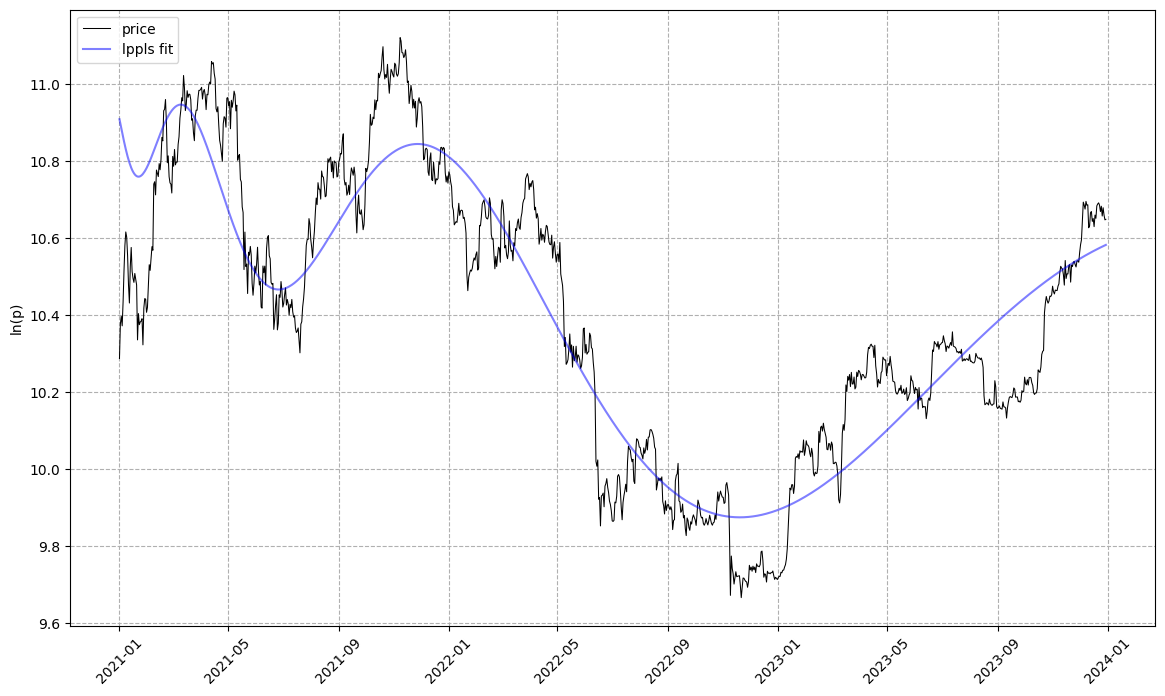

In [129]:
lppls_model.plot_fit()

In [130]:
future_dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
future_time = [pd.Timestamp.toordinal(t) for t in future_dates]

In [131]:
predicted_prices = []
for t in future_time:
    pred_price = lppls_model.lppls(t, tc, m, w, a, b, c1, c2)
    print(pred_price)
    predicted_prices.append(pred_price)

9.894913763807955
9.895806339318327
9.896717307796347
9.897646557328578
9.898593975665923
9.899559450232307
9.900542868133279
9.901544116164558
9.902563080820496
9.903599648302503
9.904653704527377
9.9057251351356
9.906813825499547
9.907919660731636
9.90904252569243
9.91018230499864
9.91133888303111
9.912512143942697
9.913701971666118
9.914908249921702
9.916130862225131
9.91736969189505
9.918624622060683
9.919895535669326
9.921182315493827
9.92248484413997
9.923803004053816
9.925136677528984
9.926485746713848
9.927850093618702
9.929229600122845
9.930624147981618
9.932033618833369
9.93345789420636
9.934896855525626
9.93635038411976
9.937818361227645
9.939300668005128
9.940797185531634
9.942307794816715
9.943832376806547
9.945370812390376
9.946922982406887
9.948488767650538
9.95006804887781
9.951660706813422
9.953266622156482
9.954885675586583
9.956517747769832
9.958162719364838
9.959820471028626
9.961490883422528
9.963173837217965
9.964869213102231
9.96657689178419
9.968296753999917
9.9

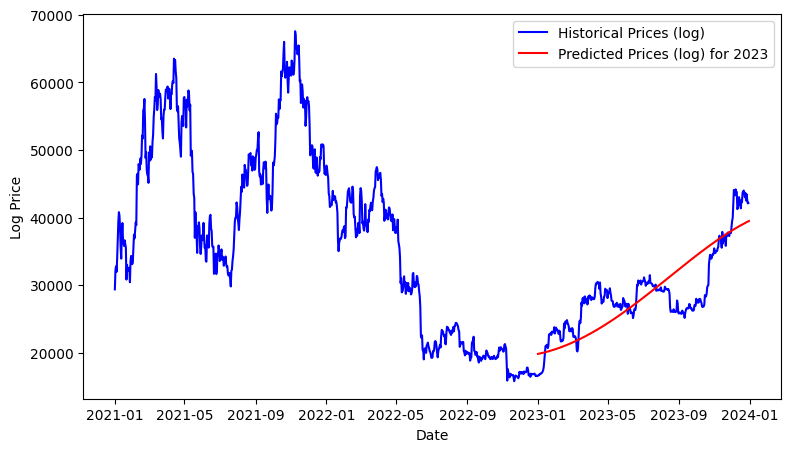

In [132]:
original_price = np.exp(price)
predicted_prices = np.exp(predicted_prices)
plt.figure(figsize=(9,5))
plt.plot(data['Date'], original_price, label="Historical Prices (log)", color='blue')
plt.plot(future_dates, predicted_prices, label="Predicted Prices (log) for 2023", color='red')
plt.xlabel('Date')
plt.ylabel('Log Price')
plt.legend()
plt.show()